## Projects:

- Diffusion Models;
- YOLO versions  - object detection;
- Segment Anything Model (https://segment-anything.com/) (Liked);
- Mathematical Integration;
- BERT fine-tuning - Text classification (compare with logistic regression and TF-IDF vectors);
- CNN visualization - review the different techniques used to analyze CNN predictions;
- Monte Carlo dropout - review briefly the concept of uncertainty and what are the main techniques used to deal with uncertainty in deep learning;
- Deep vs Wide Neural Networks - Try to understand the effect of adding layers or adding parameters in a layer;
- Overparameterization regime;
- Neural ODEs - Neural Networks and ordinary differential equations are the two main modelization techniques used nowadays, review papers explaining some evolution of the idea of Neural ODE.

General observations:

- Presentation of 15 min 
- 70% grade
- No need to submit the code

Evaluation aspects:

- Clarity
- Understanding of concepts
- Depth of research and/or experiments

## Segmenting original image

Eli Vic and Ale folder path

VIC
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Cropped_Tumors/val
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments

ELI
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images

ALE

In [ ]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)

# Path to dataset
dataset_path = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/"

# Load an example ultrasound image (Benign case)
image_path = os.path.join(dataset_path, "benign/benign (58).png")
image_name = os.path.splitext(os.path.basename(image_path))[0]
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)



c:\Users\elisa\anaconda3\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [6]:
#Stacking Masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [7]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,  # Increase to get more mask candidates
    pred_iou_thresh=0.88,  # Higher threshold keeps higher-quality masks
    stability_score_thresh=0.95,  # Ensures stable masks
    min_mask_region_area=1000  # Increase to ignore small masks
)

In [8]:
masks = mask_generator.generate(image_rgb)

In [9]:
print(len(masks))
print(masks[0].keys())
print(masks[0]['segmentation'].shape)
print(masks[0].values())

52
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
(572, 781)
dict_values([array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 1769, [208, 99, 63, 37], 0.9823189377784729, [[207.453125, 116.1875]], 0.9842961430549622, [0, 0, 781, 572]])


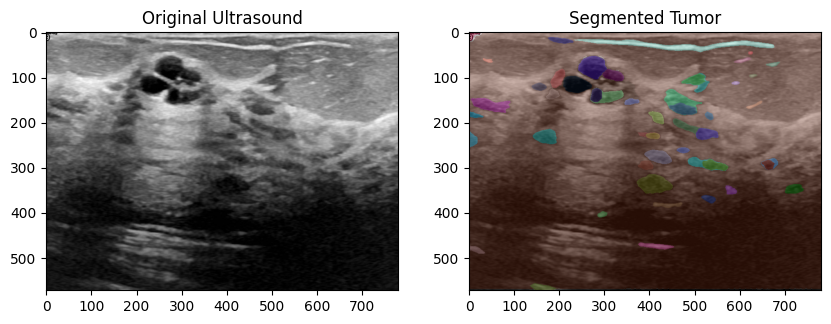

In [10]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Ultrasound")
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
show_anns(masks)
plt.title("Segmented Tumor")
plt.show()

## Defining a path for Saving Cropped image

In [18]:
image_path

'C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/benign/benign (58).png'

In [7]:

# Extract category (benign, malignant, or normal)
categories = ["benign", "malignant", "normal"]
category = next((cat for cat in categories if f"/{cat}/" in image_path), "unknown")

# Creating directory for saving cropped regions
save_path = f"./cropped_segments/{category}/"  # Save inside respective category folder
os.makedirs(save_path, exist_ok=True)

print(f"Saving path: {save_path}")


Saving path: ./cropped_segments/benign/


In [8]:
import cv2
import numpy as np
import os
import pytesseract

# Function to check if a region contains text using OCR
def contains_text(cropped_image):
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")  # PSM 6: Assume a block of text
    return bool(text.strip())  # If text is detected, return True

# Function to extract and save only non-text regions
def save_filtered_regions(image, masks, save_dir):
    for i, ann in enumerate(masks):
        mask = ann['segmentation']
        
        # Find bounding box
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip empty masks

        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Crop the region
        cropped_region = image[y_min:y_max, x_min:x_max]

        # Check if it's text; if not, save it
        if not contains_text(cropped_region):
            save_name = os.path.join(save_dir, f"{image_name}_segment_{i}.png")
            cv2.imwrite(save_name, cv2.cvtColor(cropped_region, cv2.COLOR_RGB2BGR))

save_filtered_regions(image_rgb, masks, save_path)
print(f"Filtered regions (without text) saved in: {save_path}")


Filtered regions (without text) saved in: ./cropped_segments/benign/


### Copying only the test images to the folder Breast_Image_Test

In [3]:
import os
import shutil
import pandas as pd

# Define source and destination directories
source_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images"
dest_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test"

# Read CSV file
csv_path = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/full_img_test.csv"
df = pd.read_csv(csv_path)

# Extract image names from the paths in the CSV
df["image_name"] = df["image_path"].apply(lambda x: os.path.basename(x).replace("\\", "/").split("/")[-1])


# Iterate through subfolders
for subfolder in ["benign", "malignant", "normal"]:
    source_subfolder = os.path.join(source_dir, subfolder)
    dest_subfolder = os.path.join(dest_dir, subfolder)
    
    # Create destination subfolder if it doesn't exist
    os.makedirs(dest_subfolder, exist_ok=True)
    
    # Get list of images in the subfolder
    for image_name in df["image_name"]:
        image_path = os.path.join(source_subfolder, image_name)
        if os.path.exists(image_path):  # Check if the image exists
            shutil.copy(image_path, os.path.join(dest_subfolder, image_name))

print("Copy process completed successfully!")


Copy process completed successfully!


### Segmenting all the images in the Breast_Image_Test and saving in cropped_segments

In [4]:
import torch
import numpy as np
import cv2
import os
import pandas as pd
import pytesseract
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

# Define paths
source_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test"
dest_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments"

# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)

# Define the SAM mask generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    min_mask_region_area=1000
)

# Function to check if a region contains text using OCR
def contains_text(cropped_image):
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
    text = pytesseract.image_to_string(gray, config="--psm 6")  # PSM 6: Assume a block of text
    return bool(text.strip())

# Function to segment and save non-text regions
def process_image(image_path, category):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Generate masks using SAM
    masks = mask_generator.generate(image_rgb)

    # Create save directory
    save_path = os.path.join(dest_dir, category)
    os.makedirs(save_path, exist_ok=True)

    # Extract image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    for i, ann in enumerate(masks):
        mask = ann['segmentation']

        # Find bounding box
        y_indices, x_indices = np.where(mask)
        if len(y_indices) == 0 or len(x_indices) == 0:
            continue  # Skip empty masks

        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Crop the region
        cropped_region = image_rgb[y_min:y_max, x_min:x_max]

        # Save only if it does NOT contain text
        if not contains_text(cropped_region):
            save_name = os.path.join(save_path, f"{image_name}_segment_{i}.png")
            cv2.imwrite(save_name, cv2.cvtColor(cropped_region, cv2.COLOR_RGB2BGR))

    print(f"Processed: {image_path}")

# Iterate through categories and process each image
for category in ["benign", "malignant", "normal"]:
    category_folder = os.path.join(source_dir, category)
    
    if not os.path.exists(category_folder):
        print(f"Skipping missing folder: {category_folder}")
        continue

    for image_file in os.listdir(category_folder):
        image_path = os.path.join(category_folder, image_file)
        process_image(image_path, category)

print("Segmentation and saving process completed!")


/home/sobottka/anaconda3/envs/DL/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (335).png
Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (106).png
Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (385).png
Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (319).png
Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (373).png
Processed: /home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Breast_Images_Test/benign/benign (120).png
Processed: /home

## Finding the segment containing the tumor (tumors)

In [ ]:
# IoU (Intersection over Union) Approach

import os
import cv2
import numpy as np

# Define paths
original_images_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images"
cropped_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments"

# IoU threshold to consider a segment as a tumor
IOU_THRESHOLD = 0.3

# Function to calculate IoU between two masks
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# Function to check if a segmented region contains a tumor
def is_tumor(segment_path, mask_paths):
    # Load segmented image (convert to binary mask)
    segment = cv2.imread(segment_path, cv2.IMREAD_GRAYSCALE)
    if segment is None:
        return False  # Skip if image fails to load

    segment_mask = segment > 0  # Convert to binary

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        mask_binary = mask > 0  # Convert to binary

        # Ensure the segment mask and ground truth mask have the same dimensions
        if segment_mask.shape != mask_binary.shape:
            mask_binary = cv2.resize(mask_binary.astype(np.uint8), 
                                     (segment_mask.shape[1], segment_mask.shape[0]), 
                                     interpolation=cv2.INTER_NEAREST) > 0
        
        # Compute IoU
        iou = calculate_iou(segment_mask, mask_binary)
        if iou > IOU_THRESHOLD:
            return True  # If IoU passes threshold, it's a tumor

    return False  # No overlap detected


# Iterate through categories (benign, malignant, normal)
for category in ["benign", "malignant", "normal"]:
    segment_folder = os.path.join(cropped_segments_dir, category)
    mask_folder = os.path.join(original_images_dir, category)

    if not os.path.exists(segment_folder) or not os.path.exists(mask_folder):
        print(f"Skipping {category}, folder not found.")
        continue

    # Get list of mask files for the category
    mask_files = [f for f in os.listdir(mask_folder) if "_mask" in f]
    
    # Organize masks by image name (group all masks per image)
    mask_dict = {}
    for mask_file in mask_files:
        base_name = mask_file.split("_mask")[0]  # Extract base image name
        mask_dict.setdefault(base_name, []).append(os.path.join(mask_folder, mask_file))

    # Iterate through SAM-segmented images
    for segment_file in os.listdir(segment_folder):
        segment_path = os.path.join(segment_folder, segment_file)

        # Extract base image name from SAM segment
        base_name = "".join(segment_file.split("_")[:1])  # e.g., "benign (76)"
        
        # Check if the segment overlaps with tumor masks
        if base_name in mask_dict and is_tumor(segment_path, mask_dict[base_name]):
            new_name = segment_file.replace(".png", "_tumor.png")
            new_path = os.path.join(segment_folder, new_name)

            # Rename the segmented file
            os.rename(segment_path, new_path)
            print(f"Marked as tumor: {segment_file} → {new_name}")

print("Tumor tagging process completed!")

Marked as tumor: benign (409)_segment_3.png → benign (409)_segment_3_tumor.png
Marked as tumor: benign (409)_segment_5.png → benign (409)_segment_5_tumor.png
Marked as tumor: benign (409)_segment_10.png → benign (409)_segment_10_tumor.png
Marked as tumor: malignant (142)_segment_23.png → malignant (142)_segment_23_tumor.png
Marked as tumor: malignant (23)_segment_8.png → malignant (23)_segment_8_tumor.png
Marked as tumor: malignant (170)_segment_3.png → malignant (170)_segment_3_tumor.png
Marked as tumor: malignant (137)_segment_14.png → malignant (137)_segment_14_tumor.png
Marked as tumor: malignant (142)_segment_8.png → malignant (142)_segment_8_tumor.png
Marked as tumor: malignant (186)_segment_12.png → malignant (186)_segment_12_tumor.png
Marked as tumor: malignant (137)_segment_2.png → malignant (137)_segment_2_tumor.png
Marked as tumor: malignant (133)_segment_15.png → malignant (133)_segment_15_tumor.png
Marked as tumor: malignant (133)_segment_18.png → malignant (133)_segment_1

In [ ]:
#eli trial IoU (not yet worked on it actually, I worked on pixel only)
import os
import cv2
import numpy as np

# Define paths
original_images_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Tumors/val"
cropped_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments"
output_tumor_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments_tumors"

# Pixel overlap threshold to consider as tumor
PIXEL_THRESHOLD = 500  # Adjust based on image size

# Ensure output directory exists
os.makedirs(output_tumor_segments_dir, exist_ok=True)

# Function to check if a segmented region contains a tumor
def is_tumor(segment_path, mask_paths):
    # Load segmented image (convert to binary)
    segment = cv2.imread(segment_path, cv2.IMREAD_GRAYSCALE)
    if segment is None:
        return False

    segment_mask = segment > 0  # Convert to binary
    segment_size = segment_mask.shape[:2]

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        mask_binary = mask > 0  # Convert to binary

        # Resize tumor mask to match segment size
        resized_mask = cv2.resize(mask_binary.astype(np.uint8), 
                                  (segment_size[1], segment_size[0]), 
                                  interpolation=cv2.INTER_NEAREST)

        # Compute pixel overlap
        overlap = np.logical_and(segment_mask, resized_mask).sum()
        if overlap > PIXEL_THRESHOLD:
            return True  # If overlap passes threshold, it's a tumor

    return False  # No significant overlap detected

# Organize masks by base image name (e.g., "tumor_270_mask1" -> "tumor_270")
mask_dict = {}
for mask_file in os.listdir(original_images_dir):
    if "_mask" in mask_file:
        base_name = "_".join(mask_file.split("_")[:2])  # Extract base name like "tumor_270"
        mask_dict.setdefault(base_name, []).append(os.path.join(original_images_dir, mask_file))

# Iterate through segmented images in all categories
for category in ["benign", "malignant"]:
    segment_folder = os.path.join(cropped_segments_dir, category)

    if not os.path.exists(segment_folder):
        print(f"Skipping {category}, folder not found.")
        continue

    # Iterate through SAM-segmented images
    for segment_file in os.listdir(segment_folder):
        segment_path = os.path.join(segment_folder, segment_file)

    # Extract base name (e.g., "benign (76)" or "malignant (45)")
    base_name = segment_file.split("_segment")[0].strip()

    # Debugging: Print which segments are being checked
    print(f"Checking segment: {segment_file} with base name: {base_name}")

    if base_name in mask_dict:
        print(f"Found corresponding masks for {base_name}: {mask_dict[base_name]}")
        
        if is_tumor(segment_path, mask_dict[base_name]):
            print(f"Tumor detected in: {segment_file}")
            new_name = segment_file.replace(".png", "_tumor.png")
            new_path = os.path.join(output_tumor_segments_dir, new_name)

            # Save tumor-classified segment in new folder
            segment_img = cv2.imread(segment_path)
            cv2.imwrite(new_path, segment_img)

            print(f"Saved tumor segment: {segment_file} → {new_name}")
        else:
            print(f"No tumor detected in: {segment_file}")
    else:
        print(f"No matching masks found for: {segment_file}")

print("Tumor tagging process completed!")
print(f"Total masks loaded: {len(mask_dict)}")
for key, value in mask_dict.items():
    print(f"Base mask name: {key}, Files: {value}")



Checking segment: benign (96)_segment_9.png with base name: benign (96)
No matching masks found for: benign (96)_segment_9.png
Checking segment: malignant (95)_segment_8.png with base name: malignant (95)
No matching masks found for: malignant (95)_segment_8.png
Tumor tagging process completed!
Total masks loaded: 0


In [ ]:
#Pixel Matching Approach

import os
import cv2
import numpy as np

# Define paths
original_images_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Tumors/val"
cropped_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments"

# Pixel overlap threshold to consider as tumor
PIXEL_THRESHOLD = 500  # Adjust based on image size

# Function to check if a segmented region contains a tumor
def is_tumor(segment_path, mask_paths):
    # Load segmented image (convert to binary)
    segment = cv2.imread(segment_path, cv2.IMREAD_GRAYSCALE)
    if segment is None:
        return False

    segment_mask = segment > 0  # Convert to binary
    segment_size = segment_mask.shape[:2]

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        mask_binary = mask > 0  # Convert to binary

        # Resize tumor mask to match segment size
        resized_mask = cv2.resize(mask_binary.astype(np.uint8), (segment_size[1], segment_size[0]), interpolation=cv2.INTER_NEAREST)

        # Compute pixel overlap
        overlap = np.logical_and(segment_mask, resized_mask).sum()
        if overlap > PIXEL_THRESHOLD:
            return True  # If overlap passes threshold, it's a tumor

    return False  # No significant overlap detected

# Iterate through categories (benign, malignant, normal)
for category in ["benign", "malignant", "normal"]:
    segment_folder = os.path.join(cropped_segments_dir, category)
    mask_folder = os.path.join(original_images_dir, category)

    if not os.path.exists(segment_folder) or not os.path.exists(mask_folder):
        print(f"Skipping {category}, folder not found.")
        continue

    # Get list of mask files for the category
    mask_files = [f for f in os.listdir(mask_folder) if "_mask" in f]

    # Organize masks by image name (group all masks per image)
    mask_dict = {}
    for mask_file in mask_files:
        base_name = mask_file.split("_mask")[0]  # Extract base image name
        mask_dict.setdefault(base_name, []).append(os.path.join(mask_folder, mask_file))

    # Iterate through SAM-segmented images
    for segment_file in os.listdir(segment_folder):
        segment_path = os.path.join(segment_folder, segment_file)

        # Extract base image name from SAM segment
        base_name = "_".join(segment_file.split("_")[:1])  # e.g., "benign (76)"

        # Check if the segment overlaps with tumor masks
        if base_name in mask_dict and is_tumor(segment_path, mask_dict[base_name]):
            new_name = segment_file.replace(".png", "_tumor.png")
            new_path = os.path.join(segment_folder, new_name)

            # Rename the segmented file
            os.rename(segment_path, new_path)
            print(f"Marked as tumor: {segment_file} → {new_name}")

print("Tumor tagging process completed!")


Marked as tumor: benign (198)_segment_4_tumor.png → benign (198)_segment_4_tumor_tumor.png
Marked as tumor: benign (242)_segment_0_tumor.png → benign (242)_segment_0_tumor_tumor.png
Marked as tumor: benign (100)_segment_7_tumor.png → benign (100)_segment_7_tumor_tumor.png
Marked as tumor: benign (210)_segment_5_tumor.png → benign (210)_segment_5_tumor_tumor.png
Marked as tumor: benign (421)_segment_2_tumor.png → benign (421)_segment_2_tumor_tumor.png
Marked as tumor: benign (366)_segment_0_tumor.png → benign (366)_segment_0_tumor_tumor.png
Marked as tumor: benign (421)_segment_4_tumor.png → benign (421)_segment_4_tumor_tumor.png
Marked as tumor: benign (140)_segment_1_tumor.png → benign (140)_segment_1_tumor_tumor.png
Marked as tumor: benign (210)_segment_6_tumor.png → benign (210)_segment_6_tumor_tumor.png
Marked as tumor: benign (294)_segment_0_tumor.png → benign (294)_segment_0_tumor_tumor.png
Marked as tumor: benign (336)_segment_1_tumor.png → benign (336)_segment_1_tumor_tumor.png

## first i need to rename the cropped img with the correct naming in order to match the original name (sorry for the mess)

I save them in Cropped_Test_Original_Names folder

In [42]:
import os
import shutil
import glob
import pandas as pd

# Define paths
original_images_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Tumors/val"
output_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load CSV
df_test = pd.read_csv("full_img_test.csv")
df_test.rename(columns={'Unnamed: 0': 'tumor_number'}, inplace=True)

# Extract only the final part of the image path
base_path = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/"
df_test["image_path"] = df_test["image_path"].str.replace(base_path + "benign\\", "", regex=False)
df_test["image_path"] = df_test["image_path"].str.replace(base_path + "malignant\\", "", regex=False)

# Create a mapping from tumor_number to final image name
tumor_name_mapping = dict(zip(df_test["tumor_number"].astype(str), df_test["image_path"]))

# Get all images in the original directory (including subdirectories)
all_files = glob.glob(os.path.join(original_images_dir, "**", "*.*"), recursive=True)

print(tumor_name_mapping)  # Debugging output to verify results


{'906': 'benign (58).png', '331': 'benign (131).png', '295': 'benign (113).png', '883': 'benign (47).png', '379': 'benign (155).png', '735': 'benign (375).png', '416': 'benign (171).png', '498': 'benign (210).png', '865': 'benign (432).png', '512': 'benign (228).png', '723': 'benign (37).png', '343': 'benign (137).png', '565': 'benign (292).png', '375': 'benign (153).png', '569': 'benign (294).png', '812': 'benign (409).png', '266': 'benign (1).png', '719': 'benign (368).png', '923': 'benign (67).png', '464': 'benign (192).png', '283': 'benign (106).png', '618': 'benign (322).png', '408': 'benign (168).png', '731': 'benign (373).png', '767': 'benign (39).png', '532': 'benign (25).png', '707': 'benign (362).png', '646': 'benign (335).png', '644': 'benign (334).png', '988': 'benign (96).png', '315': 'benign (124).png', '476': 'benign (197).png', '349': 'benign (140).png', '972': 'benign (9).png', '832': 'benign (418).png', '488': 'benign (202).png', '391': 'benign (160).png', '309': 'ben

In [43]:
# Extract tumor number from filename and map to index
df["tumor_number"] = df["filename"].apply(lambda x: re.search(r"tumor_(\d+)_", x).group(1) if re.search(r"tumor_(\d+)_", x) else None)

# Create a mapping from tumor_number to index
tumor_index_mapping = dict(zip(df["tumor_number"].astype(str), df["index"].astype(str)))


In [45]:
# Process images and rename them
for file_path in all_files:
    file_name = os.path.basename(file_path)
    
    # Extract tumor number from filename
    match = re.search(r"tumor_(\d+)_", file_name)
    if not match:
        print(f"Skipping file (no tumor number found): {file_name}")
        continue  # Skip files that don't match expected format
    
    tumor_number = match.group(1)  # Extract tumor number as string
    
    # Check if tumor number exists in mapping
    if tumor_number in tumor_name_mapping:
        new_filename = tumor_name_mapping[tumor_number]  # Get the corresponding new name
        
        # Extract category from filename (e.g., benign, malignant)
        category = new_filename.split(" ")[0]  # Extract first word (benign, malignant, etc.)
        category_folder = os.path.join(output_dir, category)
        os.makedirs(category_folder, exist_ok=True)  # Ensure category subdirectory exists
        
        dest_path = os.path.join(category_folder, new_filename)
        
        # Copy and rename the image
        shutil.copy(file_path, dest_path)
        print(f"Copied and renamed: {file_name} -> {new_filename}")
    else:
        print(f"No match found for tumor number: {tumor_number}")

print("Image renaming process completed!")

Copied and renamed: tumor_266_mask0.png -> benign (1).png
Copied and renamed: tumor_270_mask1.png -> benign (100).png
Copied and renamed: tumor_275_mask0.png -> benign (102).png
Copied and renamed: tumor_283_mask0.png -> benign (106).png
Copied and renamed: tumor_295_mask0.png -> benign (113).png
Copied and renamed: tumor_309_mask0.png -> benign (120).png
Copied and renamed: tumor_315_mask0.png -> benign (124).png
Copied and renamed: tumor_325_mask0.png -> benign (129).png
Copied and renamed: tumor_331_mask0.png -> benign (131).png
Copied and renamed: tumor_343_mask0.png -> benign (137).png
Copied and renamed: tumor_349_mask0.png -> benign (140).png
Copied and renamed: tumor_355_mask0.png -> benign (144).png
Copied and renamed: tumor_357_mask0.png -> benign (145).png
Copied and renamed: tumor_375_mask0.png -> benign (153).png
Copied and renamed: tumor_377_mask0.png -> benign (154).png
Copied and renamed: tumor_379_mask0.png -> benign (155).png
Copied and renamed: tumor_391_mask0.png ->

### Now I try the pixel with the new Cropped_Test_Original_Names folder where we have the cropped tumor to test 

In [51]:
#eli trial Pixel
import os
import cv2
import numpy as np
import re

# Define paths
original_images_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names"
cropped_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments"
output_tumor_segments_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments_tumors"

# Pixel overlap threshold to consider as tumor
PIXEL_THRESHOLD = 500  # Adjust based on image size

# Ensure output directory exists
os.makedirs(output_tumor_segments_dir, exist_ok=True)

# Function to check if a segmented region contains a tumor
def is_tumor(segment_path, mask_paths):
    segment = cv2.imread(segment_path, cv2.IMREAD_GRAYSCALE)
    if segment is None:
        return False

    segment_mask = segment > 0  # Convert to binary
    segment_size = segment_mask.shape[:2]

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue

        mask_binary = mask > 0  # Convert to binary
        resized_mask = cv2.resize(mask_binary.astype(np.uint8), (segment_size[1], segment_size[0]), interpolation=cv2.INTER_NEAREST)

        # Compute pixel overlap
        overlap = np.logical_and(segment_mask, resized_mask).sum()
        if overlap > PIXEL_THRESHOLD:
            return True  # If overlap passes threshold, it's a tumor

    return False  # No significant overlap detected


# Organize masks by base image name (scan subdirectories)
mask_dict = {}

for category in ["benign", "malignant"]:
    category_folder = os.path.join(original_images_dir, category)
    
    if not os.path.exists(category_folder):
        continue  # Skip if folder does not exist

    for mask_file in os.listdir(category_folder):
        base_name, _ = os.path.splitext(mask_file)  # Remove file extension (.png, .jpg, etc.)
        mask_dict.setdefault(base_name, []).append(os.path.join(category_folder, mask_file))

mask_dict

{'benign (1)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (1).png'],
 'benign (100)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (100).png'],
 'benign (102)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (102).png'],
 'benign (106)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (106).png'],
 'benign (113)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (113).png'],
 'benign (120)': ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (120).png'],
 'benign (124)': ['C:/Users/elisa/OneDrive/D

In [56]:
# Iterate through segmented images in all categories
for category in ["benign", "malignant", "normal"]:
    segment_folder = os.path.join(cropped_segments_dir, category)

    if not os.path.exists(segment_folder):
        print(f"Skipping {category}, folder not found.")
        continue

    # Iterate through segmented images
    for segment_file in os.listdir(segment_folder):
        segment_path = os.path.join(segment_folder, segment_file)

        # Extract category and index from segment file (e.g., "benign (94)_segment_14" -> "benign (94)")
        match = re.match(r'([a-zA-Z]+ \(\d+\))', segment_file)
        base_name = match.group(1) if match else None  # Keep space between name and number

        print(f"Processing file: {segment_file} | Extracted base name: {base_name}")

        # Check if the segment matches any tumor mask
        if base_name and base_name in mask_dict:
            print(f"Found matching mask for {base_name}: {mask_dict[base_name]}")

            if is_tumor(segment_path, mask_dict[base_name]):
                new_name = segment_file.replace(".png", "_tumor.png")
                output_dir = os.path.join(output_tumor_segments_dir, category)
            else:
                new_name = segment_file.replace(".png", "_normal.png")
                output_dir = os.path.join(output_tumor_segments_dir, category)

            os.makedirs(output_dir, exist_ok=True)
            new_path = os.path.join(output_dir, new_name)

            # Save the segment in the appropriate category folder
            segment_img = cv2.imread(segment_path)
            if segment_img is None:
                print(f"Error: Could not read image {segment_path}")
            else:
                cv2.imwrite(new_path, segment_img)
                print(f"Saved segment: {segment_file} → {new_name}")
        else:
            print(f"No matching mask found for: {segment_file}")

print("Tumor tagging process completed!")
print(f"Total masks loaded: {len(mask_dict)}")
for key, value in list(mask_dict.items())[:5]:  # Print only the first 5 for readability
    print(f"Mask: {key} -> {value}")

Processing file: benign (1)_segment_12.png | Extracted base name: benign (1)
Found matching mask for benign (1): ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (1).png']
Saved segment: benign (1)_segment_12.png → benign (1)_segment_12_normal.png
Processing file: benign (1)_segment_14.png | Extracted base name: benign (1)
Found matching mask for benign (1): ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (1).png']
Saved segment: benign (1)_segment_14.png → benign (1)_segment_14_normal.png
Processing file: benign (1)_segment_17.png | Extracted base name: benign (1)
Found matching mask for benign (1): ['C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Test_Original_Names\\benign\\benign (1).png']
Saved segment: benign (1)_segment_17.png → benign (1)_segment_17_normal.png
Processing fi